Import All library

In [ ]:
import csv
import nltk
import string
import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import string
import re
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns

Import dataset

In [1]:

import pandas as pd

business_path = "yelp_academic_dataset_business.json"
review_path = "yelp_academic_dataset_review.json"
b_data = pd.read_json(business_path, lines=True)

columns_to_drop = ['hours', 'is_open', 'review_count', 'longitude', 'postal_code', 'latitude', 'attributes']
b_data = b_data.drop(columns_to_drop, axis=1)
print('b_data')
print(b_data)


business_data = b_data[b_data['categories'].str.contains('Hotel', case=False, na=False)]
print('(business_data')
print(business_data)

chunk_size = 500000
r_data = pd.read_json(review_path, lines=True, chunksize=chunk_size)
print('r_data')
print(r_data)

chunks = []
for chunk in r_data:
 chunk = chunk.drop(['review_id', 'useful', 'funny', 'cool', 'user_id', 'date'], axis=1) 
 chunk = chunk.rename(columns={'stars': 'review_stars'})
 merged_data = pd.merge(business_data, chunk, on='business_id', how='inner') 
 chunks.append(merged_data)

print("Completed merging")
print(chunk)
final_dataset = pd.concat(chunks, ignore_index=True, join='outer', axis=0)
csv_name = "test.csv"
final_dataset.to_csv(csv_name, index=False)

b_data
                   business_id                      name  \
0       Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1       mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2       tUFrWirKiKi_TAnsVWINQQ                    Target   
3       MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4       mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   
...                        ...                       ...   
150341  IUQopTMmYQG-qRtBk-8QnA              Binh's Nails   
150342  c8GjPIOTGVmIemT7j5_SyQ      Wild Birds Unlimited   
150343  _QAMST-NrQobXduilWEqSw         Claire's Boutique   
150344  mtGm22y5c2UHNXDFAjaPNw  Cyclery & Fitness Center   
150345  jV_XOycEzSlTx-65W906pg                   Sic Ink   

                                address           city state  stars  \
0                1616 Chapala St, Ste 2  Santa Barbara    CA    5.0   
1       87 Grasso Plaza Shopping Center         Affton    MO    3.0   
2                  5255 E Broadway Blvd         Tucson    A

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AxBam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Data preprocessing and feature extraction

In [115]:

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess(review_text):
 print(review_text)
 remove_pctn = [char for char in review_text if char not in string.punctuation]
 remove_pctn = ''.join(remove_pctn)
 print('success remove pctn')
 lwr = [word.lower() for word in remove_pctn.split()]
 final_word = [word for word in lwr if word not in stopwords.words('english')]
 print('final word success')
 return final_word

FILE = pd.read_csv("test.csv", encoding='charmap')
file = FILE[:20000]

filtered_data = file[(file['review_stars'] == 1) | ( file['review_stars'] == 5)]
x = filtered_data['text']
y = filtered_data['review_stars']
# vectorizer = TfidfVectorizer(analyzer=preprocess)
vectorizer = TfidfVectorizer(stop_words='english',analyzer='word',vocabulary=None,max_df=0.7, min_df=1,ngram_range=(3,3)).fit(x)
x = vectorizer.transform(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)


In [6]:
i = 0
for key, value in vectorizer.vocabulary_.items():
    print(key, ' : ', value)
    if(i==20):
        break
    i= i+1
print(len(vectorizer.vocabulary_)) 

gave car  :  136123
car literally  :  51812
literally just  :  192615
just returned  :  178301
returned like  :  277635
like saw  :  190592
saw people  :  289585
people arrive  :  241264
arrive just  :  19802
just obviously  :  178129
obviously wasn  :  227481
wasn cleaned  :  366167
cleaned burn  :  64923
burn holes  :  46536
holes upholstery  :  158101
upholstery smelled  :  355079
smelled like  :  306092
like smoke  :  190676
smoke mirror  :  306486
mirror attached  :  212914
attached duct  :  22833
381376


In [7]:
file['review_stars'].value_counts()

5    7603
4    4686
1    3627
3    2216
2    1868
Name: review_stars, dtype: int64

In [8]:
len(file['business_id'].value_counts())

400

In [116]:
def conf_matrix(y, y_predict, reviews, title='Confusion_Matrix'):
 c_matrix = confusion_matrix(y, y_predict)
 clsfn_report = classification_report(y, y_predict)
 ticks = np.arange(len(reviews))
 score = accuracy_score(y_test, y_predict)
 score = round(score * 100, 2)
 print("Accuracy_score:", score)
 print('classification_report\n', clsfn_report)
 sns.heatmap(c_matrix, cmap='PuBu', annot=True, fmt='g', annot_kws={'size': 20})
 plt.xticks(ticks, reviews)
 plt.yticks(ticks, reviews)
 plt.xlabel('predicted', fontsize=20)
 plt.ylabel('actual', fontsize=20)
 plt.title(title, fontsize=20)
 plt.show()
def compute_eer(label, pred, positive_label=5):
    fpr, tpr, threshold = roc_curve(label, pred, positive_label)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer = (eer_1 + eer_2) / 2
    return eer

def AUC(X_test, y_test):
    pred_prob1 = model.predict_proba(X_test)
    fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=5)
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=5)
    auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
    print(auc_score1)
    plt.style.use('seaborn')
    plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='SVM trigram')
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.savefig('ROC',dpi=300)
    plt.show() 



LogisticRegression 

In [77]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.890353 using {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.890086 (0.005700) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.890353 (0.005932) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.890205 (0.005753) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.868329 (0.007123) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.868329 (0.007071) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.868388 (0.007069) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.755536 (0.006543) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.755536 (0.006543) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.755714 (0.006533) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.677026 (0.000408) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.677026 (0.000408) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.677026 (0.000408) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.677026 (0.000408) with: {

c:\Users\AxBam\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression with bigram

In [84]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=10000, penalty='l2', solver='lbfgs', max_iter=400)
model.fit(X_train, y_train)

LogisticRegression(C=10000, max_iter=400)

In [85]:
y_predict = model.predict(X_test)
print('predictions', len(y_predict))

predictions 2808


Accuracy_score: 88.39
classification_report
               precision    recall  f1-score   support

           1       0.98      0.66      0.79       929
           5       0.86      0.99      0.92      1879

    accuracy                           0.88      2808
   macro avg       0.92      0.83      0.86      2808
weighted avg       0.90      0.88      0.88      2808



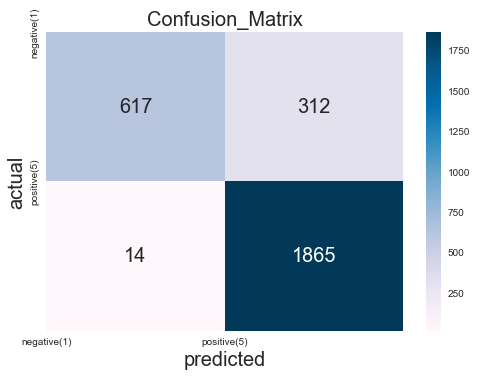

In [86]:
conf_matrix(y_test, y_predict, reviews=['negative(1)', 'positive(5)'])

0.9784033029501183


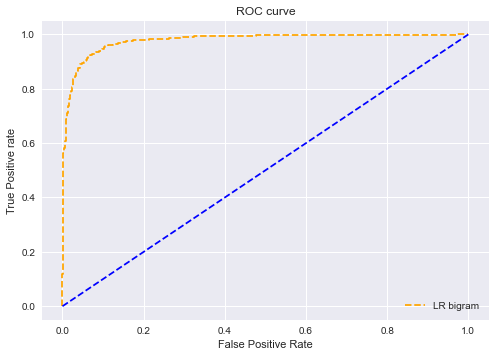

In [87]:
AUC(X_test, y_test)

In [88]:
eer = compute_eer(y_test, y_predict)
print('The equal error rate is {:.3f}'.format(eer))

The equal error rate is 0.172


c:\Users\AxBam\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass pos_label=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


LogisticRegression with trigram

In [91]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=10000, penalty='l2', solver='lbfgs', max_iter=400)
model.fit(X_train, y_train)

LogisticRegression(C=10000, max_iter=400)

In [92]:
y_predict = model.predict(X_test)
print('predictions', len(y_predict))

predictions 2808


Accuracy_score: 67.95
classification_report
               precision    recall  f1-score   support

           1       0.97      0.03      0.06       929
           5       0.68      1.00      0.81      1879

    accuracy                           0.68      2808
   macro avg       0.82      0.52      0.43      2808
weighted avg       0.77      0.68      0.56      2808



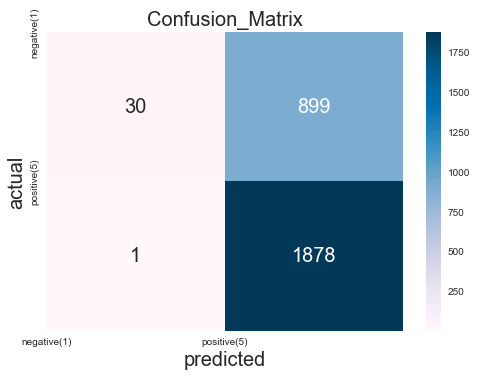

In [93]:
conf_matrix(y_test, y_predict, reviews=['negative(1)', 'positive(5)'])

0.8879886525537769


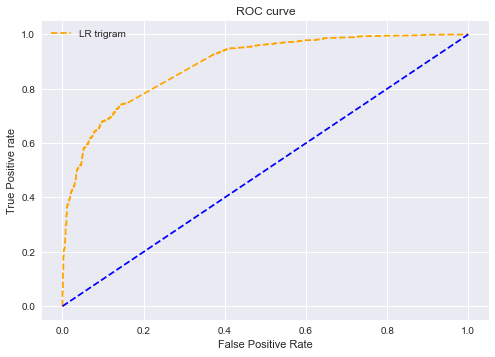

The equal error rate is 0.484


c:\Users\AxBam\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass pos_label=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [94]:
AUC(X_test, y_test)
eer = compute_eer(y_test, y_predict)
print('The equal error rate is {:.3f}'.format(eer))

MLPClassifier with hyperparameter

MLPClssifier bigram

In [21]:
model = MLPClassifier(hidden_layer_sizes=(7,7),
                        max_iter = 300,activation = 'relu',
                        learning_rate ='constant',
                        solver = 'adam')
model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(7, 7), max_iter=300)

In [22]:
y_predict = model.predict(X_test)
print('predictions', len(y_predict))

predictions 2808


Accuracy_score: 94.05
classification_report
               precision    recall  f1-score   support

           1       0.91      0.91      0.91       929
           5       0.96      0.95      0.96      1879

    accuracy                           0.94      2808
   macro avg       0.93      0.93      0.93      2808
weighted avg       0.94      0.94      0.94      2808



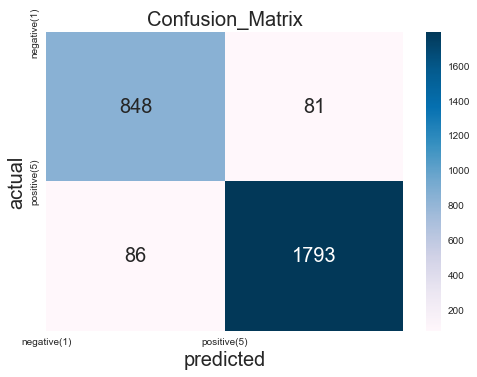

In [23]:
conf_matrix(y_test, y_predict, reviews=['negative(1)', 'positive(5)'])

0.9849821636339784


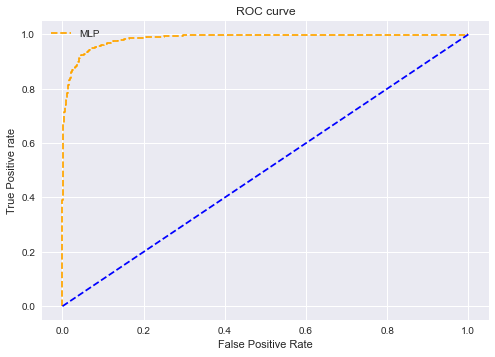

In [24]:
AUC(X_test, y_test)

In [25]:
eer = compute_eer(y_test, y_predict)
print('The equal error rate is {:.3f}'.format(eer))

The equal error rate is 0.066


c:\Users\AxBam\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass pos_label=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


MLPClssifier trigram


In [103]:
model = MLPClassifier(hidden_layer_sizes=(7,7),
                        max_iter = 300,
                        activation = 'relu',
                        learning_rate ='constant',
                        solver = 'adam')
model.fit(X_train, y_train)

c:\Users\AxBam\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(hidden_layer_sizes=(7, 7), max_iter=300)

In [30]:
y_predict = model.predict(X_test)
print('predictions', len(y_predict))

predictions 2808


Accuracy_score: 69.37
classification_report
               precision    recall  f1-score   support

           1       0.96      0.08      0.14       929
           5       0.69      1.00      0.81      1879

    accuracy                           0.69      2808
   macro avg       0.82      0.54      0.48      2808
weighted avg       0.78      0.69      0.59      2808



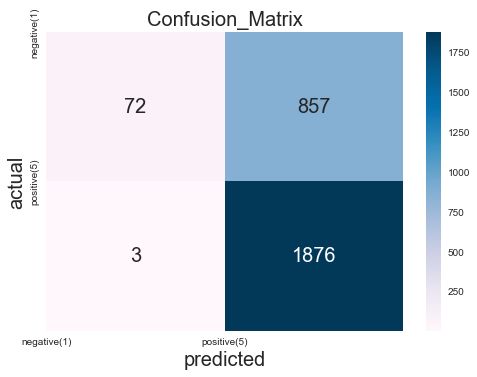

In [31]:
conf_matrix(y_test, y_predict, reviews=['negative(1)', 'positive(5)'])

0.8892713126958147


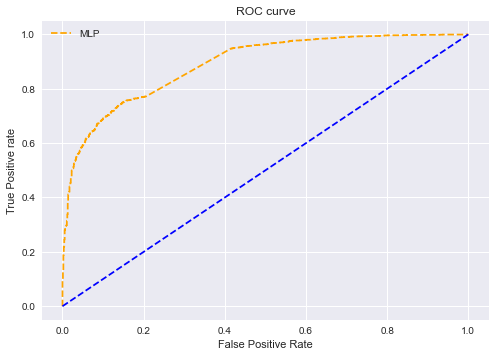

In [32]:
AUC(X_test, y_test)

In [33]:

eer = compute_eer(y_test, y_predict)
print('The equal error rate is {:.3f}'.format(eer))

The equal error rate is 0.462


c:\Users\AxBam\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass pos_label=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


MultinomialNB bigram

In [97]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [98]:
y_predict = model.predict(X_test)
print('predictions', len(y_predict))

predictions 2808


Accuracy_score: 73.58
classification_report
               precision    recall  f1-score   support

           1       0.99      0.20      0.34       929
           5       0.72      1.00      0.83      1879

    accuracy                           0.74      2808
   macro avg       0.85      0.60      0.59      2808
weighted avg       0.81      0.74      0.67      2808



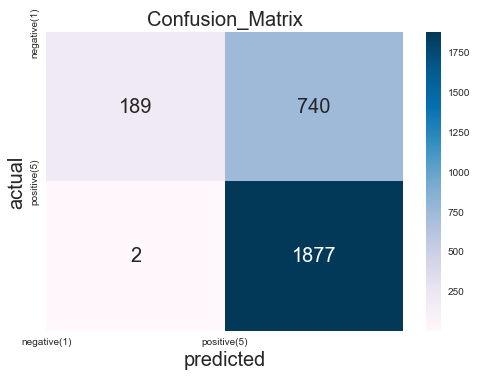

In [99]:
conf_matrix(y_test, y_predict, reviews=['negative(1)', 'positive(5)'])

0.9776494035544407


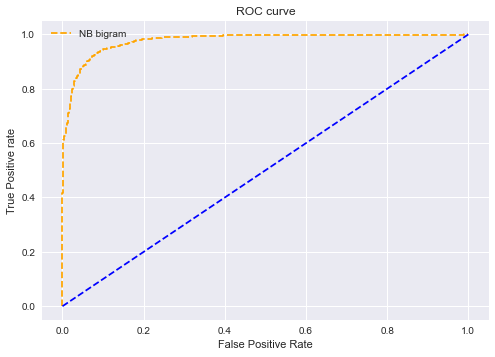

The equal error rate is 0.399


c:\Users\AxBam\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass pos_label=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [100]:
AUC(X_test, y_test)
eer = compute_eer(y_test, y_predict)
print('The equal error rate is {:.3f}'.format(eer))



MultinomialNB trigram

In [104]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [105]:
y_predict = model.predict(X_test)
print('predictions', len(y_predict))

predictions 2808


Accuracy_score: 67.2
classification_report
               precision    recall  f1-score   support

           1       0.90      0.01      0.02       929
           5       0.67      1.00      0.80      1879

    accuracy                           0.67      2808
   macro avg       0.79      0.50      0.41      2808
weighted avg       0.75      0.67      0.54      2808



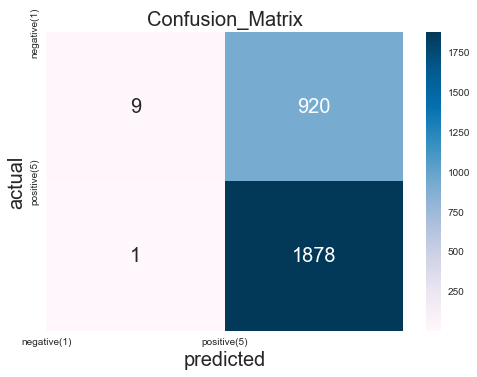

In [37]:
conf_matrix(y_test, y_predict, reviews=['negative(1)', 'positive(5)'])

0.8628155163494771


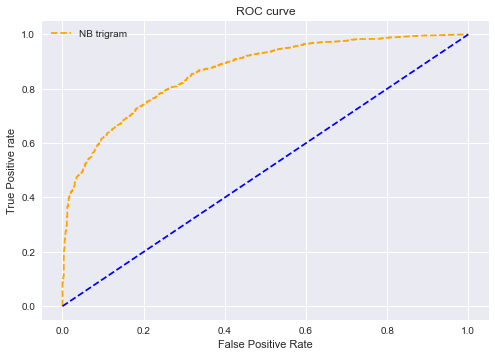

The equal error rate is 0.495


c:\Users\AxBam\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass pos_label=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [106]:
AUC(X_test, y_test)
eer = compute_eer(y_test, y_predict)
print('The equal error rate is {:.3f}'.format(eer))

SVM bigram

In [110]:
from sklearn.svm import SVC 
model = SVC(probability=True,C=1000,gamma=0.01,kernel='rbf')
model.fit(X_train, y_train)

SVC(C=1000, gamma=0.01, probability=True)

In [111]:
y_predict = model.predict(X_test)
print('predictions', len(y_predict))

predictions 2808


Accuracy_score: 89.57
classification_report
               precision    recall  f1-score   support

           1       0.97      0.70      0.82       929
           5       0.87      0.99      0.93      1879

    accuracy                           0.90      2808
   macro avg       0.92      0.85      0.87      2808
weighted avg       0.91      0.90      0.89      2808



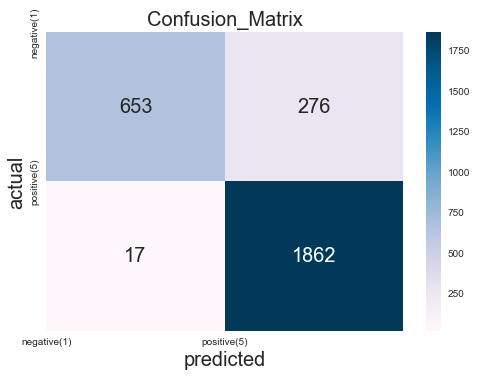

In [112]:
conf_matrix(y_test, y_predict, reviews=['negative(1)', 'positive(5)'])

0.979575398819082


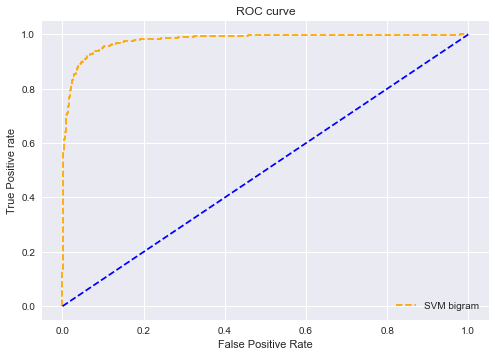

In [113]:
AUC(X_test, y_test)

In [114]:
eer = compute_eer(y_test, y_predict)
print('The equal error rate is {:.3f}'.format(eer))

The equal error rate is 0.153


c:\Users\AxBam\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass pos_label=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


SVM trigram

In [117]:
model = SVC(probability=True,C=1000,gamma=0.01,kernel='rbf')
model.fit(X_train, y_train)

SVC(C=1000, gamma=0.01, probability=True)

In [118]:
y_predict = model.predict(X_test)
print('predictions', len(y_predict))

predictions 2808


Accuracy_score: 68.2
classification_report
               precision    recall  f1-score   support

           1       0.97      0.04      0.08       929
           5       0.68      1.00      0.81      1879

    accuracy                           0.68      2808
   macro avg       0.83      0.52      0.44      2808
weighted avg       0.78      0.68      0.57      2808



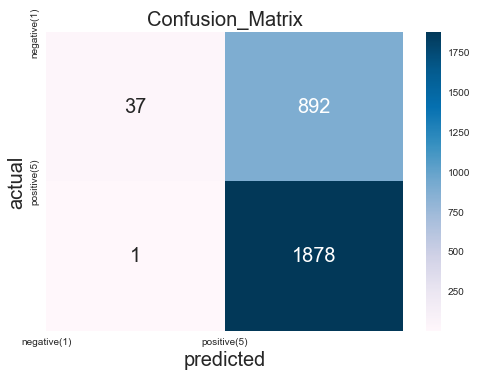

In [119]:
conf_matrix(y_test, y_predict, reviews=['negative(1)', 'positive(5)'])

0.8895915480774131


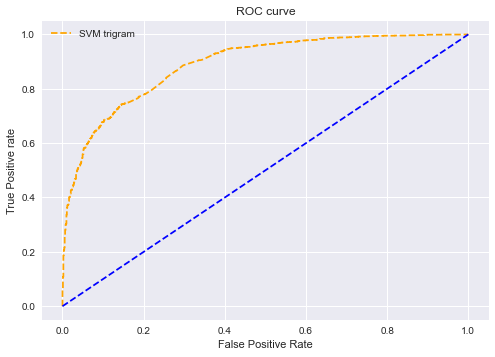

In [120]:
AUC(X_test, y_test)

In [121]:

eer = compute_eer(y_test, y_predict)
print('The equal error rate is {:.3f}'.format(eer))

The equal error rate is 0.480


c:\Users\AxBam\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass pos_label=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AxBam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\AxBam\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Show positive_comments and negative_comments

In [7]:
pos_comments = []
neg_comments = []

for idx in file.iterrows():
 i = idx[0]
 name = file['name'][i]
 t = file['text'][i]
 c_t = vectorizer.transform([t])
 predict = model.predict(c_t)[0]
 if predict == 5:
     pos_comments.append("{}-{}".format(name, t))
 else:
     neg_comments.append("{}-{}".format(name, t))

newfile = open('Pos_2.csv', 'w', encoding='charmap')
header = ['business_name', 'positive_comment']
dictwriter = csv.DictWriter(newfile, fieldnames=header)
dictwriter.writeheader()
b_name = []
p_comment = []

for row in pos_comments:
 row = row.split("-")
 if row[0] not in b_name:
     b_name.append(row[0])
 if row[1] not in p_comment:
     p_comment.append(row[1])
     token = word_tokenize(row[1])
     token = [word for word in token if word not in string.punctuation]
     bi_grams = nltk.bigrams(token)
     for gram in bi_grams:
         tags = nltk.pos_tag(gram)
         for tag in tags:
             if tag[1] == 'JJ':
                 dictwriter.writerow({'business_name': row[0], 'positive_comment': tag[0]})

newfile.close()
newfile1 = open('Neg_2.csv', 'w', encoding='charmap')
header1 = ['business_name', 'negative_comment']
dictwriter1 = csv.DictWriter(newfile1, fieldnames=header1)
dictwriter1.writeheader()
b_name1 = []
n_comment = []

for row in neg_comments:
 row = row.split("-")
 if row[0] not in b_name1:
     b_name1.append(row[0])
 if row[1] not in n_comment:
     n_comment.append(row[1])
     token = word_tokenize(row[1])
     token = [word for word in token if word not in string.punctuation]
     bi_grams = nltk.bigrams(token)
     for gram in bi_grams:
         tags = nltk.pos_tag(gram)
         for tag in tags:
             if tag[1] == 'JJ':
                 dictwriter1.writerow({'business_name': row[0], 'negative_comment': tag[0]})

newfile1.close()

In [11]:
newfile = open('Pos_context.csv', 'r', encoding='charmap')
print(newfile)

<_io.TextIOWrapper name='Pos_context.csv' mode='r' encoding='charmap'>


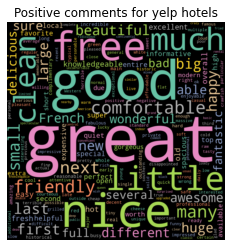

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

file = pd.read_csv('Pos_2.csv',encoding = "ISO-8859-1")
text = " ".join(line for line in file.positive_comment)

word = WordCloud(width=1000, height=1000, random_state=1, background_color='black', colormap='Set2',
              collocations=False, stopwords=STOPWORDS).generate(text)
plt.imshow(word, interpolation='bilinear')
plt.title('Positive comments for yelp hotels')
plt.axis("off")
plt.show()

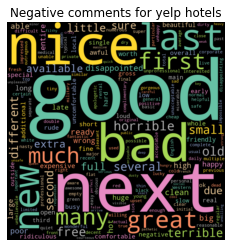

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

file = pd.read_csv('Neg_2.csv',encoding = "ISO-8859-1")
text = " ".join(line for line in file.negative_comment)

word = WordCloud(width=1000, height=1000, random_state=1, background_color='black', colormap='Set2',
              collocations=False, stopwords=STOPWORDS).generate(text)
plt.imshow(word, interpolation='bilinear')
plt.title('Negative comments for yelp hotels')
plt.axis("off")
plt.show()